In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import hydrogen as h2
from datetime import datetime

# Gasoline Demand Analysis

Currently d3ploy determines the demand from an equation. Here we compute such equation.

Data from: https://www.eia.gov/electricity/monthly/current_month/epm.pdf

Text(0.5, 0, 'Year')

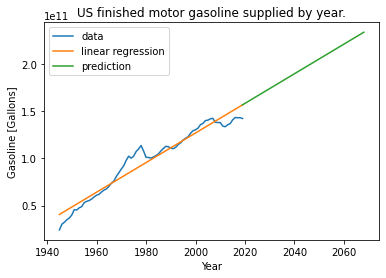

In [82]:
df = pd.read_csv ('supplied-motor-gasoline.csv')

# To retrieve the data as lists
# date = df['date'].tolist()
# volume = df['finished-motor-gasoline-supplied(thousand-barrels)'].tolist()  # [thousand-barrels]

date = df.iloc[:, :1].values
volume = df.iloc[:, 1].values  # [thousand-barrels]
volume = 1e3*volume  # [barrels]
volume = 42*volume  # [gallons]

# To convert data to dictionary
# zip(list(np.transpose(date)[0]), list(volume))
# data = dict(zip(list(np.transpose(date)[0]), list(volume)))
# data

lin = LinearRegression() 
lin.fit(date, volume)

end = 50
future = np.arange(end).reshape(end, 1) + date[-1]

plt.plot(date, volume, label='data')
plt.plot(date, lin.predict(date), label='linear regression')
plt.plot(future, lin.predict(future), label='prediction')
plt.legend(loc="upper left")
plt.title('US finished motor gasoline supplied by year.')
plt.ylabel('Gasoline [Gallons]')
plt.xlabel('Year')
# plt.savefig("fuel-demand", dpi=300, bbox_inches="tight")

## Hydrogen Production meets fuel demand over time

Deployment of new HTGRs that produce only Hydrogen.

Chosen HTGR: **GT-MHR**.

P = 600 MW$_{th}$

T$_{o}$ = 850 $^\circ$C

https://www-pub.iaea.org/MTCD/Publications/PDF/TE_1674_CD_web.pdf

The production meets the demand in year:  2168


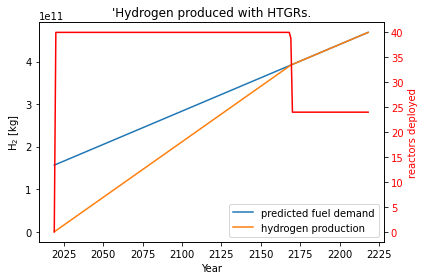

In [14]:
Pth = 600
pr = h2.hte1_prod_rate(Pth, 850)[1]  # [kg/h]
pr *= 365*24  # [kg/y]

end = 200
future = np.arange(end).reshape(end, 1) + date[-1]
fuel_demand = lin.predict(future)

rdr = 40*np.ones(end)  # reactor deployment rate
rdr[0] = 0
rdc = np.cumsum(rdr)  # reactor deployment cumulative

hydrogen = pr*rdc

for t in range(end):
    if hydrogen[t] < fuel_demand[t]:
        tintersect = t+future[0]
    else:
        hydrogen[t] = np.ceil(fuel_demand[t])
        rdc[t] = np.ceil(fuel_demand[t])/pr
        rdr[t] = rdc[t]-rdc[t-1]

print("The production meets the demand in year: ", tintersect[0])

fig, ax1 = plt.subplots()
ax1.plot(future, fuel_demand, label='predicted fuel demand')
ax1.plot(future, hydrogen, label='hydrogen production')
ax1.legend(loc="lower right")
ax1.set_title("'Hydrogen produced with HTGRs.", color="black")
ax1.set_ylabel('H$_2$ [kg]', color="black")
ax1.set_xlabel('Year')
ax2 = ax1.twinx()
ax2.plot(future, rdr, color='red')
ax2.set_ylabel('reactors deployed', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()

## CO$_2$ savings

Burning a gallon of gasoline produces 19.64 lbs of CO$_2$.
For each kg-H_2 we are saving 19.64 lbs of CO$_2$.

Text(0.5, 0, 'Year')

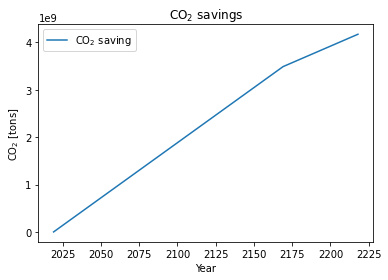

In [39]:
carbon = hydrogen*19.64  # [lbs]
carbon *= 0.453592  # [kg]
carbon /= 1000  # [metric tons]

plt.plot(future, carbon, label='CO$_2$ saving')
plt.legend(loc="upper left")
plt.title('CO$_2$ savings')
plt.ylabel('CO$_2$ [tons]')
plt.xlabel('Year')

## Future Work: D3ploy

D3ploy should be able to carry out this analysis on its own, but currently takes a function of time as the demand. If we can set this data as the demand in the initial years, then we wouldn't need the previous analysis.

D3ploy uses dictionaries. Retrieve the data and build a dictionary.

Another thing I could do, is just predict the demand with d3ploy functions, and see what happens.

In [6]:
data = pd.read_csv('supplied-motor-gasoline.csv', header=0, index_col=0, squeeze=True).to_dict()

scaling = 42 * 1e3
total = {key: scaling * data[key] for key, values in data.items()}
print(total)

{1945: 24332406000.0, 1946: 30345504000.0, 1947: 32483136000.0, 1948: 35051100000.0, 1949: 36948282000.0, 1950: 40100466000.0, 1951: 45761772000.0, 1952: 45401580000.0, 1953: 47672646000.0, 1954: 48956334000.0, 1955: 53090688000.0, 1956: 54535992000.0, 1957: 55420554000.0, 1958: 56885262000.0, 1959: 59171784000.0, 1960: 61011552000.0, 1961: 61977132000.0, 1962: 64369536000.0, 1963: 66441732000.0, 1964: 67676616000.0, 1965: 70404768000.0, 1966: 73707144000.0, 1967: 76010886000.0, 1968: 80865834000.0, 1969: 84713790000.0, 1970: 88676658000.0, 1971: 92201256000.0, 1972: 98018676000.0, 1973: 102318552000.0, 1974: 100219392000.0, 1975: 102321576000.0, 1976: 107261028000.0, 1977: 110020680000.0, 1978: 113622936000.0, 1979: 107838066000.0, 1980: 101125374000.0, 1981: 100986816000.0, 1982: 100246608000.0, 1983: 101517528000.0, 1984: 102877362000.0, 1985: 104721162000.0, 1986: 107832270000.0, 1987: 110463738000.0, 1988: 112776132000.0, 1989: 112336140000.0, 1990: 110911164000.0, 1991: 110184648

## Analysis for different types of reactors and hydrogen production methods

**LWR** fleet Data:

Installed capacity (2019): 99.39 million kW [1].

96 reactors [2].


HTGR Data: Data correspond to **GT-MHR**

P = 600 MW$_{th}$ [3]

T$_o$  = 850 $^\circ$C [3]

References:

[1] https://www.eia.gov/electricity/monthly/current_month/epm.pdf

[2] https://www.eia.gov/tools/faqs/faq.php?id=207&t=3

[3] https://www-pub.iaea.org/MTCD/Publications/PDF/TE_1674_CD_web.pdf

### Future work
* Add more reactor types, maybe MSR and FBR. Efficiency for those?

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

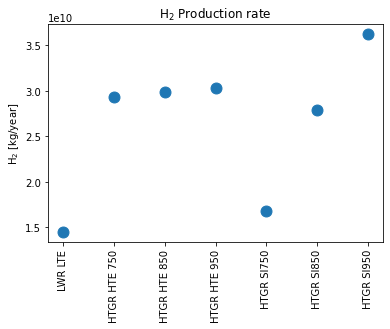

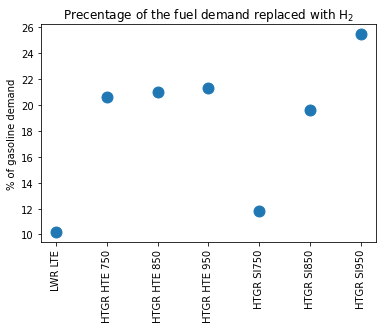

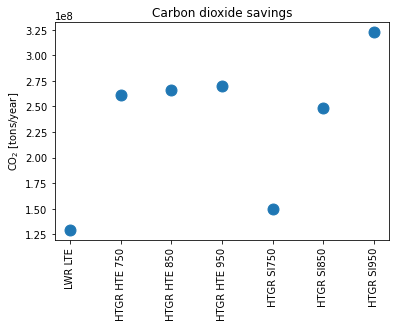

In [26]:
installed = 99.4e6  # [kW]
installed /= 1e3*0.33  # [MW-th]

carbon = hydrogen*19.64  # [lbs]
carbon *= 0.453592  # [kg]
carbon /= 1000  # [metric tons]

pr = []
fuel = []
carbon = []
xlab = []

pro = 365*24*h2.lte_prod_rate(installed, 0.33)[1]  # [kg/y]
pr.append(pro)
fuel.append(pr/volume[-1]*100)
carbon.append(pro*19.64*0.453592/1e3)  # [tons/y]
xlab.append('LWR LTE')

for tout in [750, 850, 950]:
    pro = 365*24*h2.hte1_prod_rate(installed, tout)[1]
    pr.append(pro)  # [kg/y]
    fuel.append(pro/volume[-1]*100)
    carbon.append(pro*19.64*0.453592/1e3)  # [tons/y]
    xlab.append('HTGR HTE '+ str(tout))

for tout in [750, 850, 950]:
    pro = 365*24*h2.si_prod_rate(installed, tout)[1]  # [kg/y]
    pr.append(pro)  # [kg/y]
    fuel.append(pro/volume[-1]*100)
    carbon.append(pro*19.64*0.453592/1e3)  # [tons/y]
    xlab.append('HTGR SI' + str(tout))
    
plt.figure(1)
plt.scatter(xlab, pr, marker='o', s=120)
plt.title('H$_2$ Production rate')
plt.ylabel('H$_2$ [kg/year]')
plt.xticks(rotation=90)

plt.figure(2)
plt.scatter(xlab, fuel, marker='o', s=120)
plt.title('Precentage of the fuel demand replaced with H$_2$')
plt.ylabel('% of gasoline demand')
plt.xticks(rotation=90)

plt.figure(3)
plt.scatter(xlab, carbon, marker='o', s=120)
plt.title('Carbon dioxide savings')
plt.ylabel('CO$_2$ [tons/year]')
plt.xticks(rotation=90)

# Off-peak hydrogen production

Daily data:
https://www.eia.gov/beta/electricity/gridmonitor/dashboard/electric_overview/US48/US48

Yearly data:
https://www.eia.gov/totalenergy/data/browser/index.php?tbl=T07.02A#/?f=A&start=1949&end=2019&charted=5-15-13

We consider that the hourly demand changes proportionally to the yearly demand change:

hourly$_{2019 + 50}$ / hourly$_{2019}$ = total$_{2019 + 50}$ / total$_{2019}$

### Future work:
* By state ?
* Economics: Company (e.g. Exelon) cells H2 to transportation during off peak

R$^2$ score:  0.017506885090182722
4151117.127683516
R$^2$ score:  0.9857697260155478
R$^2$ score:  0.7901336951305641


/home/roberto/.local/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/roberto/.local/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/roberto/.local/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/roberto/.local/lib/python3.7/site-packages/dat

ustg: 1.0080296613830406
ustg %: 0.0002590213349367942
ussg: 6.117750091528658
ussg %: 0.1650887126299567


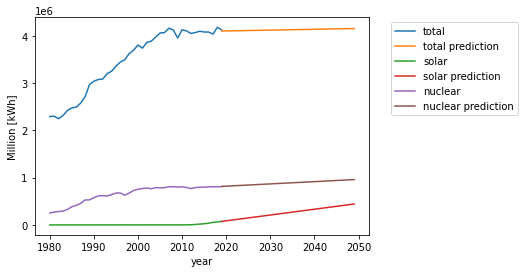

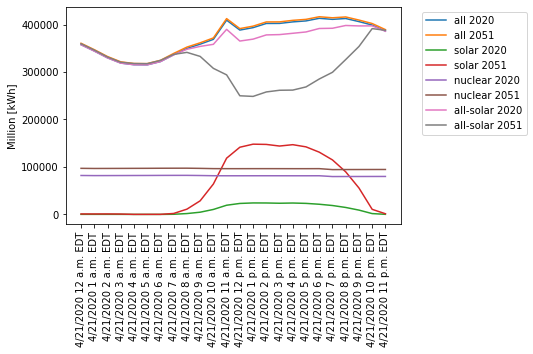

In [7]:
def get_prediction(syear, stime, elec, fut, plotflag, title, name=0):
    """
    Parameters:
    -----------
    - syear: [int]
    data used for prediction starts at syear and
    ends at last year.
    - stime: [list]
    list of years of the electricity generation data.
    - elec: [list]
    list of electricity generation data.
    - fut: [int]
    number of years to do the prediction for.
    - plotflag: [bool]
    False: no plotting.
    Returns:
    --------
    - future: [list]
    years of the prediction.
    - ytf: [list]
    prediction of electricity generation.
    """
    sstime = stime[stime.index(syear):]
    yt = elec[stime.index(syear):]
    sstime = np.array(sstime).reshape(len(sstime),1)
    yt = np.array(yt)
    lin = LinearRegression()
    lin.fit(sstime, yt)
    print(r'R$^2$ score: ', lin.score(sstime, yt))
    pt = lin.predict(sstime)
    future = np.arange(fut).reshape(fut, 1) + stime[-1]
    ytf = lin.predict(future)
    
    if plotflag == True:
        plt.figure()
        plt.plot(stime, elec, label='data')
        plt.plot(sstime, pt, label='regression')
        plt.plot(future, ytf, label='prediction')
        plt.legend(loc='upper left')
        plt.xlabel('year')
        plt.ylabel('Million [kWh]')
        plt.title(title+' electricity net generation.')
        plt.savefig("figures/"+name, dpi=300, bbox_inches="tight")
        # plt.show()
        plt.close()

    return future, ytf

df = pd.read_csv ('electricity-year.csv')
time = df['Annual Total'].tolist()
solar = df["Electricity Net Generation From Solar, All Sectors (Million Kilowatthours)"].tolist()
nuclear = df["Electricity Net Generation From Nuclear Electric Power, All Sectors (Million Kilowatthours)"].tolist()
total = df["Electricity Net Generation Total (including from sources not shown), All Sectors (Million Kilowatthours)"].tolist()

for i in range(len(solar)):
    if solar[i] == 'Not Available':
        solar[i] = 0
    else:
        solar[i] = float(solar[i])
       
# plt.figure(1)
# plt.plot(time, total, label='total')
# plt.plot(time, solar, label='solar')
# plt.plot(time, nuclear, label='nuclear')
# plt.legend(loc='upper left')
# plt.xlabel('year')
# plt.ylabel('Million [kWh]')
# plt.title('Electricity net generation by sector by year.')

zyear = 1980
ztime = time[time.index(zyear):]
ztotal = total[time.index(zyear):]
zsolar = solar[time.index(zyear):]
znuclear = nuclear[time.index(zyear):]

predict = 31
future1, ytf1 = get_prediction(2006, ztime, ztotal, predict, True, 'Total', 'us-prediction1')
print(ytf1[-1])
future2, ytf2 = get_prediction(2015, ztime, zsolar, predict, True, 'Solar', 'us-prediction2')
future3, ytf3 = get_prediction(2012, ztime, znuclear, predict, False, 'nuclear')

plt.figure()
plt.plot(ztime, ztotal, label='total')
plt.plot(future1, ytf1, label='total prediction')
plt.plot(ztime, zsolar, label='solar')
plt.plot(future2, ytf2, label='solar prediction')
plt.plot(ztime, znuclear, label='nuclear')
plt.plot(future3, ytf3, label='nuclear prediction')
# plt.legend(loc='upper left')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True)
plt.xlabel('year')
plt.ylabel('Million [kWh]')
plt.savefig("figures/us-prediction", dpi=300, bbox_inches="tight")

df = pd.read_csv ('electricity-hour.csv')
time = df['Timestamp (Hour Ending)'].tolist()
solar = df['Solar Generation (MWh)'].tolist()
nuclear = df['Nuclear Generation (MWh)'].tolist()
total = df['Total Generation (MWh)'].tolist()

# choose date and time
sdate = '4/21/2020'
stime = '12 a.m. EDT'
edate = '4/22/2020'
etime = '12 a.m. EDT'

s = time.index(sdate+' '+stime)
e = time.index(edate+' '+etime)

ntime = time[s:e]
nsolar = np.array(solar[s:e])
nnuclear = np.array(nuclear[s:e])
ntotal = np.array(total[s:e])

# plt.figure(1)
# plt.plot(ntime, nsolar, label='solar')
# plt.plot(ntime, nnuclear, label='nuclear')
# plt.plot(ntime, ntotal, label='others')
# plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True) 
# plt.xticks(rotation=90)
# plt.ylabel('Electricity generated [MWh]')
# plt.title('US electricity generated by energy source on {0}'.format(sdate))

plt.figure()
plt.plot(ntime, ntotal, label='all 2020')
ustg = ytf1[-1]/ztotal[-1]
print('ustg:', ustg)
print('ustg %:', (ustg-1)/predict)
nntotal = ustg*ntotal
plt.plot(ntime, nntotal, label='all {0}'.format(2020+predict))

plt.plot(ntime, nsolar, label='solar 2020')
ussg = ytf2[-1]/zsolar[-1]
print('ussg:', ussg)
print('ussg %:', (ussg-1)/predict)
nnsolar = ussg*nsolar
plt.plot(ntime, nnsolar, label='solar {0}'.format(2020+predict))

plt.plot(ntime, nnuclear, label='nuclear 2020')
usng = ytf3[-1]/znuclear[-1]
nnnuclear = usng*nnuclear
plt.plot(ntime, nnnuclear, label='nuclear {0}'.format(2020+predict))

plt.plot(ntime, ntotal-nsolar, label='all-solar 2020')
plt.plot(ntime, nntotal-nnsolar, label='all-solar {0}'.format(2020+predict))

plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True)
plt.ylabel('Million [kWh]')
plt.savefig("figures/duck-curve", dpi=300, bbox_inches="tight")

4/17/2019 2 p.m. EDT
['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00', '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']


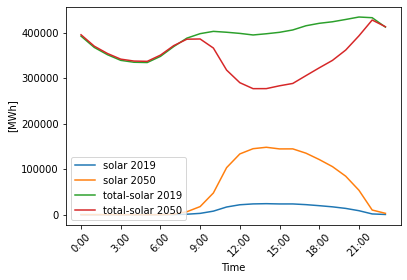

In [12]:
df = pd.read_csv ('us-hourly3.csv')
time = df['Timestamp (Hour Ending)'].tolist()
solar = df['Solar Generation (MWh)'].tolist()
nuclear = df['Nuclear Generation (MWh)'].tolist()
total = df['Total Generation (MWh)'].tolist()

time_max = time[solar.index(max(solar))]
print(time_max)

# choose date and time
sdate = '4/17/2019'
stime = '12 a.m. EDT'
edate = '4/18/2019'
etime = '12 a.m. EDT'

s = time.index(sdate+' '+stime)
e = time.index(edate+' '+etime)

ntime = time[s:e]
nsolar = np.array(solar[s:e])
ntotal = np.array(total[s:e])

ntime = [str(i)+':00' for i in range(24)]
print(ntime)

plt.figure()
# plt.plot(ntime, ntotal, label='total 2019')
nntotal = ustg*ntotal
# plt.plot(ntime, nntotal, label='total {0}'.format(2019+predict))
plt.plot(ntime, nsolar, label='solar 2019')
nnsolar = ussg*nsolar
plt.plot(ntime, nnsolar, label='solar {0}'.format(2019+predict))

plt.plot(ntime, ntotal-nsolar, label='total-solar 2019')
plt.plot(ntime, nntotal-nnsolar, label='total-solar {0}'.format(2019+predict))

plt.xticks(np.arange(0, 24, step=3), rotation=45)
#plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True)
plt.legend(loc="lower left")
plt.ylabel('[MWh]')
plt.xlabel('Time')
# plt.title('Prediction on US demand in the US for 2050.')
plt.savefig("figures/duck-curve4", dpi=300, bbox_inches="tight")

I got the duck curve but...
Nuclear energy should be larger to be affected ...

Myabe we can say that a way to mitigate that is having fast systems as natural gas plants, but a more suitable solution would be having nuclear reactors that operate at constant power, and during the times when the electricity is not needed from those, they could produce hydrogen.

Let's try by state/region, maybe in Illinois, that nuclear energy is more abundant:

Text(0, 0.5, 'Million [kWh]')

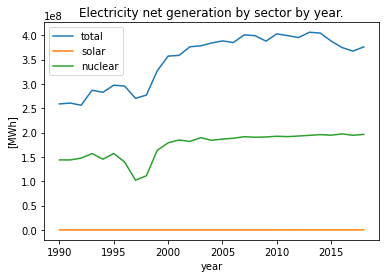

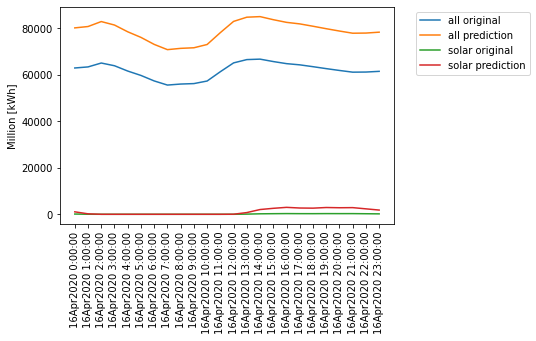

In [93]:
def get_cut(syear, cstate, csource):
    time = []
    elec = []           
    il=0
    gen = 0
    while il < len(yearl):
        if yearl[il] < yearl[-1]:
            i = 0
            if yearl[il] >= syear:
                change = False
                while change == False and (il+i+1) < len(yearl):
                    if yearl[il+i+1] > yearl[il+i]:
                        time.append(yearl[il+i])
                        elec.append(gen)
                        change = True
                    else:
                        i += 1
                        if statel[il+i] == cstate and sourcel[il+i] == csource:
                            gen += int(genel[il+i].replace(',' , ''))
                gen = 0
            il += i+1
        else:
            if statel[il] == cstate and sourcel[il] == csource:
                gen += int(genel[il].replace(',' , ''))
            il += 1
    time.append(yearl[-1])
    elec.append(gen)
    return time, elec

    
df = pd.read_csv ('1990-2018-bystate.csv')
yearl = df['YEAR'].tolist()
statel = df['STATE'].tolist()
sourcel = df['ENERGY SOURCE'].tolist()
genel = df['GENERATION (MWh)'].tolist()

ztime, ztotal = get_cut(1990, 'IL', 'Total')
ztime, zsolar = get_cut(1990, 'IL', 'Solar Thermal and Photovoltaic')
ztime, znuclear = get_cut(1990, 'IL', 'Nuclear')

plt.figure(1)
plt.plot(ztime, ztotal, label='total')
plt.plot(ztime, zsolar, label='solar')
plt.plot(ztime, znuclear, label='nuclear')
plt.legend(loc='upper left')
plt.xlabel('year')
plt.ylabel('[MWh]')
plt.title('Electricity net generation by sector by year.')

predict = 100
future1, ytf1 = get_prediction(2000, ztime, ztotal, predict, False, 'total')
future2, ytf2 = get_prediction(2010, ztime, zsolar, predict, False, 'solar')
future3, ytf3 = get_prediction(2000, ztime, znuclear, predict, False, 'nuclear')

# HERE
df = pd.read_csv ('MIDW-hourly.csv')
time = df['UTC time'].tolist()
solar = df['Solar'].tolist()
nuclear = df['Nuclear'].tolist()
total = df['Net generation'].tolist()

# choose date and time
sdate = '16Apr2020'
stime = '0:00:00'
edate = '17Apr2020'
etime = '0:00:00'

s = time.index(sdate+' '+stime)
e = time.index(edate+' '+etime)

ntime = time[s:e]
nsolar = np.array(solar[s:e])
nuclear = nuclear[s:e]
nnuclear = np.zeros(len(nuclear))
for i in range(len(nuclear)):
    nnuclear[i] = int(nuclear[i].replace(',' , ''))
total = total[s:e]
ntotal = np.zeros(len(total))
for i in range(len(total)):
    ntotal[i] = int(total[i].replace(',' , ''))

# plt.figure(2)
# plt.plot(ntime, nsolar, label='solar')
# plt.plot(ntime, nnuclear, label='nuclear')
# plt.plot(ntime, ntotal, label='total')
# plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True) 
# plt.xticks(rotation=90)
# plt.ylabel('Electricity generated [MWh]')
# plt.title('US electricity generated by energy source on {0}'.format(sdate))

plt.figure(2)
plt.plot(ntime, ntotal, label='all original')
nntotal = ytf1[-1]/ztotal[-1]*ntotal
plt.plot(ntime, nntotal, label='all prediction')
plt.plot(ntime, nsolar, label='solar original')
nnsolar = ytf2[-1]/zsolar[-1]*nsolar
plt.plot(ntime, nnsolar, label='solar prediction')

# plt.plot(ntime, nnuclear, label='nuclear original')
# nnnuclear = ytf3[-1]/znuclear[-1]*nnuclear
# plt.plot(ntime, nnnuclear, label='solar prediction')
# plt.plot(ntime, nntotal-nnsolar, label='all-solar prediction')

plt.xticks(rotation=90)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fancybox=True)
plt.ylabel('Million [kWh]')


Unluckily, solar energy in Illinois, seems to be to small, I should check my numbers.
Another thing to try is to see the duck curve with the university grid. Let's see what data we have.

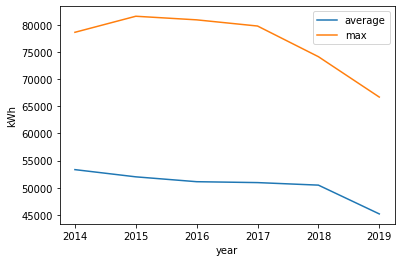

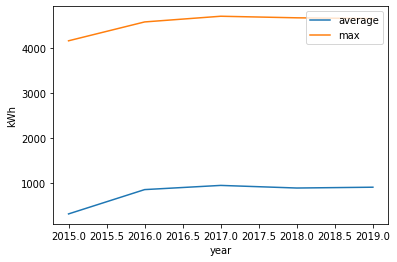

In [5]:
def get_data(start, end, time, data):
    # get average by year
    s = time.index(start)
    e = time.index(end)
    values = data[s:e+1]
    values = np.array(values)
    values[values < 0] = 0
    ave = sum(values)/len(values)
    max_val = max(values)
    return ave, max_val

df = pd.read_csv('2014-2019-uiuc-electricity-demand.csv')
timel = df['time'].tolist()
total = df['kw'].tolist()

years = np.arange(2014, 2020)
ave_year = []
max_year = []
ave2014, max2014 = get_data('2014-07-01 00:00:00', '2014-12-31 23:00:00', timel, total)
ave_year.append(ave2014)
max_year.append(max2014)
ave2015, max2015 = get_data('2015-01-01 00:00:00', '2015-12-31 23:00:00', timel, total)
ave_year.append(ave2015)
max_year.append(max2015)
ave2016, max2016 = get_data('2016-01-01 00:00:00', '2016-12-31 23:00:00', timel, total)
ave_year.append(ave2016)
max_year.append(max2016)
ave2017, max2017 = get_data('2017-01-01 00:00:00', '2017-12-31 23:00:00', timel, total)
ave_year.append(ave2017)
max_year.append(max2017)
ave2018, max2018 = get_data('2018-01-01 00:00:00', '2018-12-31 23:00:00', timel, total)
ave_year.append(ave2018)
max_year.append(max2018)
ave2019, max2019 = get_data('2019-01-01 00:00:00', '2019-06-30 23:00:00', timel, total)
ave_year.append(ave2019)
max_year.append(max2019)

plt.figure(1)
plt.plot(years, ave_year, label='average')
plt.plot(years, max_year, label='max')
plt.legend(loc='upper right')
plt.xlabel('year')
plt.ylabel('kWh')

df = pd.read_csv('2015-2019-uiuc-solar.csv')
timel = df['time'].tolist()
solarl = df['measured'].tolist()

years = np.arange(2015, 2020)
ave_year = []
max_year = []
ave2015, max2015 = get_data('2015-11-18 00:00:00', '2015-12-31 23:45:00', timel, solarl)
ave_year.append(ave2015)
max_year.append(max2015)
ave2016, max2016 = get_data('2016-01-01 00:00:00', '2016-12-31 23:45:00', timel, solarl)
ave_year.append(ave2016)
max_year.append(max2016)
ave2017, max2017 = get_data('2017-01-01 00:00:00', '2017-10-29 11:30:00', timel, solarl)
ave_year.append(ave2017)
max_year.append(max2017)
ave2018, max2018 = get_data('2018-01-30 10:30:00', '2018-12-31 23:45:00', timel, solarl)
ave_year.append(ave2018)
max_year.append(max2018)
ave2019, max2019 = get_data('2019-01-01 00:00:00', '2019-10-03 23:45:00', timel, solarl)
ave_year.append(ave2019)
max_year.append(max2019)

plt.figure(2)
plt.plot(years, ave_year, label='average')
plt.plot(years, max_year, label='max')
plt.legend(loc='upper right')
plt.xlabel('year')
plt.ylabel('kWh')
plt.savefig("figures/solar-uiuc", dpi=300, bbox_inches="tight")

The data yearly doesn't seem to be enough to make a good prediction, I will use the growth factor of the whole US.

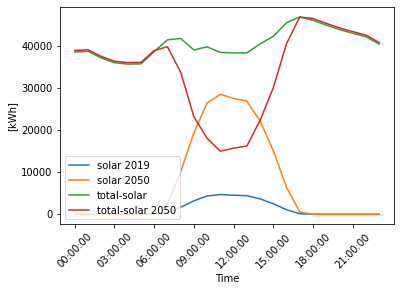

In [13]:
df = pd.read_csv('2015-2019-uiuc-solar.csv')

timeh = df['time'].tolist()
solarh = df['measured'].tolist()

s = timeh.index('2018-10-03 00:00:00')
e = timeh.index('2019-10-03 23:45:00')
timev = timeh[s:e+1]
solarv = solarh[s:e+1]
time_max = timev[solarv.index(max(solarv))]
day = datetime.fromisoformat(time_max)
s = timev.index(str(day.date())+' 00:00:00')
e = timev.index(str(day.date())+' 23:45:00')
timed = timev[s:e+1]
valsol = solarv[s:e+1]

plt.figure(1)
# plt.plot(timed, valsol, label='solar')

df = pd.read_csv('2014-2019-uiuc-electricity-demand.csv')

timeh = df['time'].tolist()
totalh = df['kw'].tolist()

s = timeh.index(str(day.date())+' 00:00:00')
e = timeh.index(str(day.date())+' 23:00:00')
timed = timeh[s:e+1]
valtot = totalh[s:e+1]

A = np.zeros((len(valtot), len(valsol)))
for i in range(A.shape[0]):
    A[i, 4*i:4*(i+1)] = 0.25*np.ones(4)
nvalsol = A @ np.array(valsol)

# timep = []
# for i in range(len(timed)):
#     aux = datetime.fromisoformat(timed[i])
#     print(aux.time())
# print(timep)

timep = [str(datetime.fromisoformat(timed[i]).time()) for i in range(len(timed))]

plt.plot(timep, nvalsol, label='solar 2019')
nnvalsol = ussg*nvalsol
plt.plot(timep, nnvalsol, label='solar {0}'.format(2019+predict))

valtot = np.array(valtot)
totmsol = valtot-nvalsol
#plt.plot(timep, valtot, label='total 2019')
nvaltot = ustg*valtot
#plt.plot(timep, nvaltot, label='total {0}'.format(2019+predict))
plt.plot(timep, totmsol, label='total-solar')
ntotmsol = nvaltot-nnvalsol
plt.plot(timep, ntotmsol, label='total-solar {0}'.format(2019+predict))
plt.xticks(np.arange(0, 24, step=3), rotation=45)
plt.ylabel('[kWh]')
plt.xlabel('Time')
# plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
plt.legend(loc="lower left")
# plt.title('Prediction on UIUC demand by hour for {0}.'.format(2019+predict))
plt.savefig("figures/uiuc-duck", dpi=300, bbox_inches="tight")

### How much H2 can be produced with differnet reactor sizes?

39607.24827065756
75.75757575757576
50.16617825745122


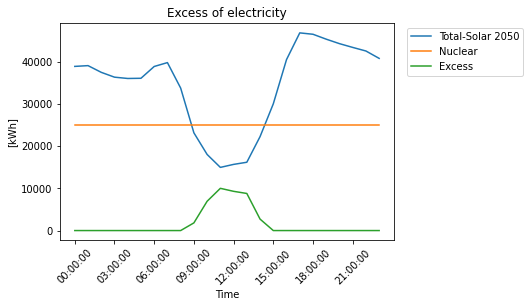

<Figure size 432x288 with 0 Axes>

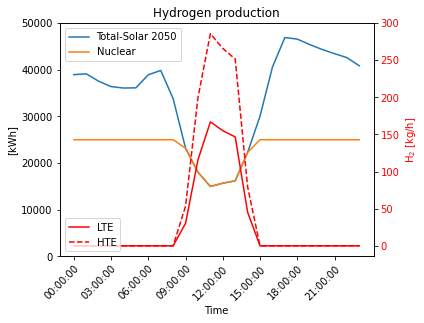

In [14]:
reactor_size = 25e3  # kW
reactor = reactor_size*np.ones(len(nvalsol))
h2energy = reactor-ntotmsol
h2energy[h2energy < 0] = 0
print(sum(h2energy))
# Do it for one case for the plot

plt.figure(1)
plt.plot(timep, ntotmsol, label='Total-Solar {0}'.format(2019+predict))
plt.plot(timep, reactor, label='Nuclear')
plt.plot(timep, h2energy, label='Excess')
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
plt.xticks(np.arange(0, 24, step=3), rotation=45)
plt.ylabel('[kWh]')
plt.xlabel('Time')
plt.title('Excess of electricity')
plt.savefig("figures/uiuc-hydro1", dpi=300, bbox_inches="tight")

PE = reactor-h2energy  # [kWh]
beta = PE/reactor_size

eta1 = 0.33
Pth1 = reactor_size/eta1/1e3  # [MW_{th}h]
print(Pth1)
h2prod1 = h2.lte_prod_rate((1-beta)*Pth1, eta1)[1]

tout = 850
eta2 = h2.efficiency(tout)
Pth2 = reactor_size/eta2/1e3  # [MW_{th}h]
print(Pth2)
h2prod2 = []
h2prod2 = [h2.hte1_prod_rate((1-be)*Pth2, tout)[1] for be in beta]

plt.figure(2)
fig, ax1 = plt.subplots()
ax1.plot(timep, ntotmsol, label='Total-Solar {0}'.format(2019+predict))
ax1.plot(timep, PE, label='Nuclear')
# ax1.legend(loc="lower right")
# ax1.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
ax1.legend(loc="upper left")
ax1.set_title("Hydrogen production", color="black")
ax1.set_ylabel('[kWh]', color="black")
ax1.set_ylim(0, 50e3) 

ax2 = ax1.twinx()
ax2.plot(timep, h2prod1, label='LTE', color='red')
ax2.plot(timep, h2prod2, '--', label='HTE', color='red')
#ax2.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0))
ax2.legend(loc="lower left")

ax2.set_ylabel('H$_2$ [kg/h]', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()

timelabel = []
for i in range(0, 24, 3):
    timelabel.append(timep[i])

ax1.set_xticklabels(timelabel)
ax1.set_xticks(timelabel)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax1.set_xlabel('Time')
plt.savefig("figures/uiuc-hydro2", dpi=300, bbox_inches="tight")

Two posibilities from here:
* Reactor produces H2 and sells it to transportation.
* Reactor produces H2 and uses it on the grid at peak.

We suppose 60% efficient, the fuel cells.

660.12 kg/day
1135.93 kg/day
15842.9 kWh/day
27262.35 kWh/day
level1:  41889.65896713171
level2:  39986.4175383811
sanity check 1:  15081.795216217026
sanity check 2:  24863.16282846382
old peak: 46888.76639545371
new peak1: 41889.65896713171
peak reduction 1: 4999.1074283220005 kW
new peak2: 41889.65896713171
peak reduction 2: 6902.348857072611 kW


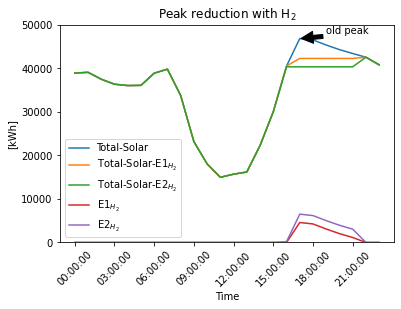

In [15]:
total1 = sum(h2prod1)
total2 = sum(h2prod2)
print(round(total1, 2), 'kg/day')
print(round(total2, 2), 'kg/day')
elect1 = 0.6*h2.electricity(total1)
elect2 = 0.6*h2.electricity(total2)
print(round(elect1, 2), 'kWh/day')
print(round(elect2, 2), 'kWh/day')

sdistribute = '16:00:00'
s = timep.index(sdistribute)
distribute = 6

level1 = (sum(ntotmsol[s:s+distribute])-elect1)/distribute
print("level1: ", level1)
level2 = (sum(ntotmsol[s:s+distribute])-elect2)/distribute
print("level2: ", level2)

new_tot_sol1 = ntotmsol.copy()
new_tot_sol2 = ntotmsol.copy()
new_hydro_elect1 = np.zeros(len(ntotmsol))
new_hydro_elect2 = np.zeros(len(ntotmsol))
for i in range(s, s+distribute):
    if new_tot_sol1[i] >= level1*1.01:
        new_tot_sol1[i] = level1*1.01
        new_hydro_elect1[i] = ntotmsol[i]-new_tot_sol1[i]
    if new_tot_sol2[i] >= level2*1.01:
        new_tot_sol2[i] = level2*1.01
        new_hydro_elect2[i] = ntotmsol[i]-new_tot_sol2[i]
        
print('sanity check 1: ', sum(new_hydro_elect1))
print('sanity check 2: ', sum(new_hydro_elect2))

opeak = max(ntotmsol)
print('old peak:', opeak)
find = ntotmsol.tolist().index(max(ntotmsol))
print('new peak1:', level1)
print('peak reduction 1:', opeak-level1, 'kW')
print('new peak2:', level1)
print('peak reduction 2:', opeak-level2, 'kW')

plt.plot(timep, ntotmsol, label = 'Total-Solar')
plt.plot(timep, new_tot_sol1, label = 'Total-Solar-E1$_{H_2}$')
plt.plot(timep, new_tot_sol2, label = 'Total-Solar-E2$_{H_2}$')
plt.plot(timep, new_hydro_elect1, label = 'E1$_{H_2}$')
plt.plot(timep, new_hydro_elect2, label = 'E2$_{H_2}$')
plt.xticks(np.arange(0, 24, step=3), rotation=45)
# plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.0), fancybox=True)
plt.legend(loc="lower left")
plt.annotate('old peak', xy=(find, opeak), xytext=(find+2, opeak+1e3),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.ylim(0, 50e3)
plt.ylabel('[kWh]')
plt.xlabel('Time')
plt.title('Peak reduction with H$_2$')
plt.savefig("figures/uiuc-hydro3", dpi=300, bbox_inches="tight")

### More:

Would this be considered savings? We consider that when there is a peak, UIUC purchases the electricity from the grid at 7.9 cents/kWh. Then we estimate that the electricity purchased around the peak at 5 pm (4-10 pm) has that same cost. So UIUC would be saving 7.9cents/kWh every hour.

The following numbers came from those assumptions. (I believe 7.9 is just an average, so this is way underestimated). I also don't know where the electricity comes from during a peak. Abbot maybe?

In [113]:
# money savings
ca = 7.9e-2
savings1 = elect1*ca
print(savings1*365)
savings2 = elect2*ca
print(savings2*365)

434501.3217393793
690807.372859357


CO2 from natural gas:

https://www.eia.gov/tools/faqs/faq.php?id=74&t=11

In [117]:
m2018 = 523*1e6*1e3  # kg
e2018 = 1246847*1e6  # kWh
ca = m2018/e2018*2.20462

savings1 = elect1*ca
print(savings1*365/1e6, 'thousand tons of CO2/year')
savings2 = elect2*ca
print(savings2*365/1e6, 'thousand tons of CO2/year')

5.086116196273183 thousand tons of CO2/year
8.086342645724727 thousand tons of CO2/year


Install Draw.io to make diagrams: I need one explaining what beta is.

https://blog.jupyter.org/a-diagram-editor-for-jupyterlab-a254121ff919

jupyter labextension install jupyterlab-drawio

## Another

Look at data that Katy sent me, make economics analysis. Maybe carry out previous analysis by state.


## Another2

Serpent unit cell depletion calculation of PWR and HTGR:
- Fuel composition of PWR
- Fuel shape of PWR
- Fuel composition of HTGR
- Fuel shape of HTGR

## Another3

Make energy consumption preductions with d3ploy.

import d3ploy.NO_solver as dn or something like that